In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def load_change_events(change_events_file):
    """
    Load the change events from a JSON file.
    """
    if not os.path.exists(change_events_file):
        raise FileNotFoundError(f"{change_events_file} does not exist")
    with open(change_events_file, 'r') as f:
        events = json.load(f)
    return events

def extract_features(events):
    """
    Convert the change events into a feature matrix.
    This example assumes each event contains an "object_id".
    The features include:
      - Change magnitude statistics (mean, std, min, max, median, quant90, quant95, quant99)
      - Convex hull properties (hull surface area, volume, and ratio)
      - Geometric features from both epochs
    """
    rows = []
    for event in events:
        row = {}
        # Change magnitude statistics
        change_mags = event.get('change_magnitudes', {})
        for stat in ['mean', 'std', 'min', 'max', 'median', 'quant90', 'quant95', 'quant99']:
            row[f'change_{stat}'] = change_mags.get(stat, np.nan)
        
        # Convex hull properties
        convex_hull = event.get('convex_hull', {})
        row['hull_surface_area'] = convex_hull.get('surface_area', np.nan)
        row['hull_volume'] = convex_hull.get('volume', np.nan)
        row['hull_surf_vol_ratio'] = convex_hull.get('surface_area_to_volume_ratio', np.nan)
        
        # Geometric features from both epochs (if available)
        geom = event.get('geometric_features_both_epochs', {})
        for feat in ['sum_of_eigenvalues', 'omnivariance', 'eigentropy', 'anisotropy',
                     'planarity', 'linearity', 'surface_variation', 'sphericity', 'verticality']:
            row[f'geom_{feat}'] = geom.get(feat, np.nan)
        
        # Unique identifier and event type (if provided)
        row['object_id'] = event.get('object_id')
        row["event_type"] = event.get('event_type', np.nan)
        
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

def classify_event(row, rules):
    """
    Classify an event based on a set of rule conditions provided in 'rules'.
    
    The rules dictionary should have the following structure:
    
      rules = {
          "label_name": {
              "feature1": {"min": value, "max": value},
              "feature2": {"min": value}
              ...
          },
          ... 
      }
    
    For each label, the event is considered a match if for every specified feature:
       - The feature value is not NaN.
       - If a "min" is specified, the value is >= the min.
       - If a "max" is specified, the value is <= the max.
       
    The function returns the first label (in iteration order) which all its conditions are met.
    If none match, "unclassified" is returned.
    """
    for label, conditions in rules.items():
        meets_conditions = True
        for feature, thresholds in conditions.items():
            value = row.get(feature, np.nan)
            if pd.isna(value):
                meets_conditions = False
                break
            if "min" in thresholds and value < thresholds["min"]:
                meets_conditions = False
                break
            if "max" in thresholds and value > thresholds["max"]:
                meets_conditions = False
                break
        if meets_conditions:
            return label
    return "unclassified"

### Define rules

In [3]:
# Define a dictionary for rule-based classification.
# You can easily add new classes or adjust thresholds by modifying this dictionary.
classification_rules = {
    "large_change": {
         "change_mean": {"min": 0.2, "max": 10},
         "hull_volume": {"min": 100}
    },
    "small_change": {
         "change_mean": {"max": 0.2}
    },
    "specific_change": {
         "change_mean": {"min": 1, "max": 5},
         "hull_volume": {"min": 5, "max": 10}
    },
}


### Load the data

In [4]:
# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)

# Path to the unlabelled change events test file
change_events_file = "../test_data/change_events_unlabelled.json"
labelled_file = os.path.join(os.path.dirname(change_events_file), 'change_events_labelled_rule_based.json')

# Load the change events
events = load_change_events(change_events_file)

### Extract features from the events

In [5]:
# Extract features into a DataFrame
features_df = extract_features(events)

In [6]:
# Apply the generic classification function using the rules in classification_rules
features_df['event_type'] = features_df.apply(lambda row: classify_event(row, classification_rules), axis=1)


### Save clustered change events

In [7]:
# Create a mapping from object_id to the chosen cluster label (event_type)
label_mapping = dict(zip(features_df['object_id'], features_df['event_type']))

# Update the original events by matching them by object_id.
for event in events:
    obj_id = event.get('object_id')
    if obj_id in label_mapping:
        event['event_type'] = label_mapping[obj_id]
    else:
        # Mark events dropped due to missing features as None
        event['event_type'] = None

# Save the updated events to a new JSON file.
with open(labelled_file, 'w') as f:
    json.dump(events, f, indent=4)

### Visualize classification

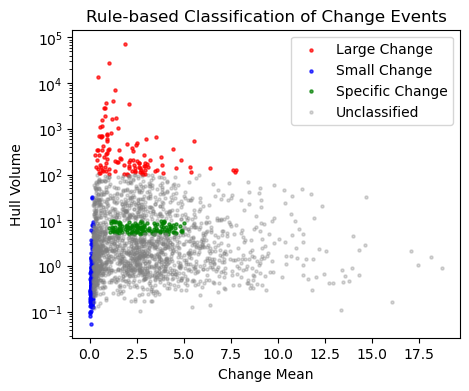

In [8]:
# Plot large events:
large_events = features_df[features_df['event_type'] == 'large_change']
plt.figure(figsize=(5, 4))
plt.scatter(large_events['change_mean'], large_events['hull_volume'], label='Large Change', alpha=0.7,s=5, color = 'red')
# Plot small events:
small_events = features_df[features_df['event_type'] == 'small_change']
plt.scatter(small_events['change_mean'], small_events['hull_volume'], label='Small Change', alpha=0.7,s=5, color = 'blue')
# Plot specific events:
specific_events = features_df[features_df['event_type'] == 'specific_change']
plt.scatter(specific_events['change_mean'], specific_events['hull_volume'], label='Specific Change', alpha=0.7,s=5, color = 'green')
# Plot unclassified events:
unclassified_events = features_df[features_df['event_type'] == 'unclassified']
plt.scatter(unclassified_events['change_mean'], unclassified_events['hull_volume'], label='Unclassified', alpha=0.3, color='gray',s=5)

plt.yscale('log')
plt.legend()
plt.xlabel('Change Mean')
plt.ylabel('Hull Volume')
plt.title('Rule-based Classification of Change Events')
plt.show()